In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import astropy.units as u
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import eispac

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

In [6]:
eis_atlas_30_fex_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5"
eis_atlas_30_fexiv_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5"
eis_ch_fex_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
eis_ch_fexiv_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5"

In [7]:
eis_atlas_30_shiftx, eis_atlas_30_shifty = 4.5*u.arcsec, -4*u.arcsec
eis_ch_shiftx, eis_ch_shifty = -4.096*u.arcsec, -2.505*u.arcsec

eis_atlas_30_fex_fitres =  eispac.read_fit(eis_atlas_30_fex_filename)
eis_atlas_30_fex_intmap = eis_atlas_30_fex_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fex_intmap_shifted = eis_atlas_30_fex_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_atlas_30_fexiv_fitres =  eispac.read_fit(eis_atlas_30_fexiv_filename)
eis_atlas_30_fexiv_intmap = eis_atlas_30_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fexiv_intmap_shifted = eis_atlas_30_fexiv_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_ch_fex_fitres =  eispac.read_fit(eis_ch_fex_filename)
eis_ch_fex_intmap = eis_ch_fex_fitres.get_map(component=0, measurement='intensity')
eis_ch_fex_intmap_shifted = eis_ch_fex_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

eis_ch_fexiv_fitres =  eispac.read_fit(eis_ch_fexiv_filename)
eis_ch_fexiv_intmap = eis_ch_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_ch_fexiv_intmap_shifted = eis_ch_fexiv_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [24]:
eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2017-08-21T21:09:50.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T21:09:50.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (8.71063623e-15, 6.93331769, 1.51320798e+11)>): (Tx, Ty) in arcsec
    (-931.76660824, 328.22927856)>

In [8]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [9]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [10]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def plot_eis_fov(ax,eis_map,color="red",alpha=0.7,label="EIS"):
    eis_xstart = eis_map.bottom_left_coord.Tx.value
    eis_ystart = eis_map.bottom_left_coord.Ty.value
    eis_fovx = eis_map.dimensions.x * eis_map.scale.axis1
    eis_fovy = eis_map.dimensions.y * eis_map.scale.axis2
    rectangle = patches.Rectangle((eis_xstart, eis_ystart),
                            eis_fovx.value, eis_fovy.value,linewidth=2,edgecolor=color,
                            facecolor="none",alpha=alpha,label=label)
    ax.add_patch(rectangle)

In [11]:
FeXIV_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.02413460883717655 0.044890372437148385


In [12]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [31]:
mask_bad_fit_matrix_ext = np.where(np.any(np.abs(green_fit_matrix_ext_err/green_fit_matrix_ext)[:3,:,:] > 0.5,axis=0) | \
                np.any(np.isnan(green_fit_matrix_ext_err),axis=0))
mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(green_fit_matrix_bin_ext_err/green_fit_matrix_bin_ext)[:3,:,:] > 0.2,axis=0) | \
                np.any(np.isnan(green_fit_matrix_bin_ext_err),axis=0))

kernel = Gaussian2DKernel(x_stddev=1,y_stddev=2)
kernel_bin = Gaussian2DKernel(x_stddev=1,y_stddev=0.2)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 970**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
# green_line_int_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_int_masked = interpolate_replace_nans(green_line_int_masked,kernel)
green_line_int_masked[green_where_disk_ext] = np.nan

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:]+green_fit_matrix_ext[4,:,:])
# green_cont_masked[mask_bad_fit_matrix_ext] = np.nan
# green_cont_masked = interpolate_replace_nans(green_cont_masked, kernel)
green_cont_masked[green_where_disk_ext] = np.nan

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/(green_fit_matrix_ext[3,:,:]+green_fit_matrix_ext[4,:,:])
# green_line_cont_ratio_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_cont_ratio_masked = interpolate_replace_nans(green_line_cont_ratio_masked,kernel)
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[mask_bad_fit_matrix_bin_ext] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
# green_vlos_masked = interpolate_replace_nans(green_vlos_masked,kernel_bin)
green_vlos_masked[green_where_disk_bin_ext] = np.nan


green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[mask_bad_fit_matrix_bin_ext] = np.nan
# green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
# green_veff_masked = interpolate_replace_nans(green_veff_masked,kernel_bin)
green_veff_masked[green_where_disk_bin_ext] = np.nan

green_fwhm_masked_err = np.copy(green_fit_matrix_bin_ext_err[2,:,:])
green_fwhm_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan     
green_veff_masked_err = green_fwhm_masked/np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)* \
    green_fwhm_masked_err/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [79]:
def veff2teff(veff):
    return 55.85*const.u.cgs.value*(veff*1e5)**2/2/const.k_B.cgs.value/1e6

def teff2veff(teff):
    return np.sqrt(2*const.k_B.cgs.value*teff*1e6/(55.85*const.u.cgs.value))/1e5

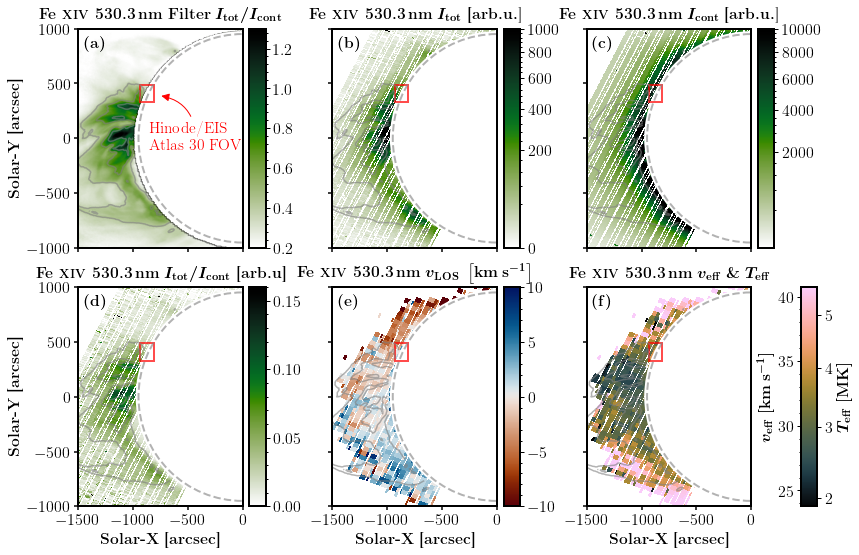

In [91]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

colorbar_width = "10%"

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

def create_lunar_mask(rmoon):
    return patches.Circle((0,0),rmoon,linewidth=0,edgecolor="none",
                            facecolor="white",alpha=1)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11,7.6),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.3,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

# for ax_ in (ax2,ax3,ax4,ax5,ax6):
#     ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
#                     cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

norm_green_line_int = ImageNormalize(data=green_line_int_masked,interval=ManualInterval(0,1000),stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmr.jungle_r,rasterized=True,shading="auto",
                norm=norm_green_line_int)


plot_colorbar(im2, ax2,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

norm_green_cont_int = ImageNormalize(data=green_cont_masked,interval=ManualInterval(1e2,1e4),stretch=SqrtStretch())

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmr.jungle_r,rasterized=True,norm=norm_green_cont_int)

im3_clb, im3_clbax = plot_colorbar(im3, ax3,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
# im3_clbax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# im3_clbax.yaxis.get_offset_text().set_fontsize(16)
# im3_clbax.yaxis.get_offset_text().set(va="bottom",ha="left")
# im3_clbax.yaxis.get_offset_text().set_position((1,2))

im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmr.jungle_r,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im4, ax4,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)


plot_colorbar(im5, ax5,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.12/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))


clb6, clb_ax6 = plot_colorbar(im6, ax6,width=colorbar_width,bbox_to_anchor=(1.3, 0., 1, 1),fontsize=16)
clb_ax6.yaxis.set_ticks_position("left")
clb_ax6.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=16)
clb_ax6.yaxis.set_label_position("left")
clb_ax6_teff = clb_ax6.secondary_yaxis("right",functions=(veff2teff, teff2veff))
clb_ax6_teff.tick_params(labelsize=16)
clb_ax6_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=16)


ax1.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax4.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax4.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax5.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax6.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)

ax1.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm Filter} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax3.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm cont}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax4.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=16,pad=10)
ax5.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)
ax6.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm eff}\ \&\ T_{\rm eff}}$",fontsize=16,pad=10)

for ax_, text_ in zip((ax1,ax2,ax3,ax4,ax5,ax6),
                      ("a","b","c","d","e","f")):
    ax_.text(0.035,0.97,r"\textbf{("+text_+r")}",fontsize=16,
             va="top",ha="left",transform=ax_.transAxes)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]



for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    plot_eis_fov(ax_,eis_atlas_30_fexiv_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}") 
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/ms/FeXIV_fit.pdf",dpi=300,format="pdf",bbox_inches="tight")

In [28]:
FeXIV_in_atlas30_FOV = np.where( \
((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green) > eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green) < eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Tx.value + 32) & \
((y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green) > eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green) < eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Ty.value + 160))

In [66]:
green_veff_in_atlas30_FOV = green_veff_masked[FeXIV_in_atlas30_FOV]
green_veff_err_in_atlas30_FOV = green_veff_masked_err[FeXIV_in_atlas30_FOV]
green_veff_in_atlas30_FOV,green_veff_err_in_atlas30_FOV = np.unique([green_veff_in_atlas30_FOV,green_veff_err_in_atlas30_FOV],axis=1)
green_veff_in_atlas30_FOV = green_veff_in_atlas30_FOV[~np.isnan(green_veff_in_atlas30_FOV)]
green_veff_err_in_atlas30_FOV = green_veff_err_in_atlas30_FOV[~np.isnan(green_veff_err_in_atlas30_FOV)]

In [67]:
green_veff_in_atlas30_FOV, green_veff_err_in_atlas30_FOV

(array([29.70661373, 29.90392211, 32.11086826, 32.5963626 , 35.07219842]),
 array([0.45921181, 0.79590378, 0.70621775, 0.5580869 , 0.9585173 ]))

In [68]:
green_veff_in_atlas30_aver = np.nansum(green_veff_in_atlas30_FOV/green_veff_err_in_atlas30_FOV**2)/np.nansum(1./green_veff_err_in_atlas30_FOV**2)
green_veff_in_atlas30_aver_err = np.sqrt(1./(green_veff_in_atlas30_FOV.shape[0] - 1)* \
(np.nansum(green_veff_in_atlas30_FOV**2/green_veff_err_in_atlas30_FOV**2)/np.nansum(1./green_veff_err_in_atlas30_FOV**2) - green_veff_in_atlas30_aver**2))

In [69]:
print("Average Fe XIV veff in Atlas 30 FOV: {:.2f} +/- {:.2f}".format(green_veff_in_atlas30_aver,green_veff_in_atlas30_aver_err))

Average Fe XIV veff in Atlas 30 FOV: 31.31 +/- 0.86


In [16]:
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeX_52.h5", 'r') as hf:
    red_fit_matrix_ext = hf['red_fit_matrix_ext'][:]
    red_fit_matrix_ext_err = hf['red_fit_matrix_ext_err'][:]
    red_fit_matrix_bin_ext = hf['red_fit_matrix_bin_ext'][:]
    red_fit_matrix_bin_ext_err = hf['red_fit_matrix_bin_ext_err'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]

In [17]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-51,125,1,dtype=np.float64) + 4
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,87.5,176) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

In [18]:
FeX_xslice = slice(602,652)
pixel_size_red = np.abs(np.mean(np.diff((red_frame_wavelength/52/10.)[FeX_xslice])))
inst_width_pix_red = 2.12
inst_width_nm_red = pixel_size_red*inst_width_pix_red

img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

In [19]:
slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [20]:
red_mask_bad_fit_matrix_ext = np.where(np.any(np.abs(red_fit_matrix_ext_err/red_fit_matrix_ext)[:3,:,:] > 0.5,axis=0) | \
                np.any(np.isnan(red_fit_matrix_ext_err),axis=0))
red_mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(red_fit_matrix_bin_ext_err/red_fit_matrix_bin_ext)[:3,:,:] > 0.2,axis=0) | \
                np.any(np.isnan(red_fit_matrix_bin_ext_err),axis=0))


red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 970**2)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
# red_line_int_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_int_masked = interpolate_replace_nans(red_line_int_masked,kernel)
red_line_int_masked[red_where_disk_ext] = np.nan

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:]+red_fit_matrix_ext[4,:,:])
# red_cont_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_cont_masked = interpolate_replace_nans(red_cont_masked, kernel)
red_cont_masked[red_where_disk_ext] = np.nan

# red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
# red_line_cont_ratio_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_cont_ratio_masked = interpolate_replace_nans(red_line_cont_ratio_masked,kernel)
# red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
red_line_cont_ratio_masked = red_line_int_masked/red_cont_masked

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
red_vlos_masked_err = red_fit_matrix_bin_ext_err[0,:,:]/637.451*const.c.cgs.value*1e-5
red_vlos_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked_err[red_where_disk_bin_ext] = np.nan

red_fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
red_fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked[red_where_disk_bin_ext] = np.nan
red_fwhm_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err = np.copy(red_fit_matrix_bin_ext_err[2,:,:])
red_fwhm_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err[red_where_disk_bin_ext] = np.nan

red_veff_masked = np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
red_veff_masked_err = red_fwhm_masked/np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)* \
    red_fwhm_masked_err/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt


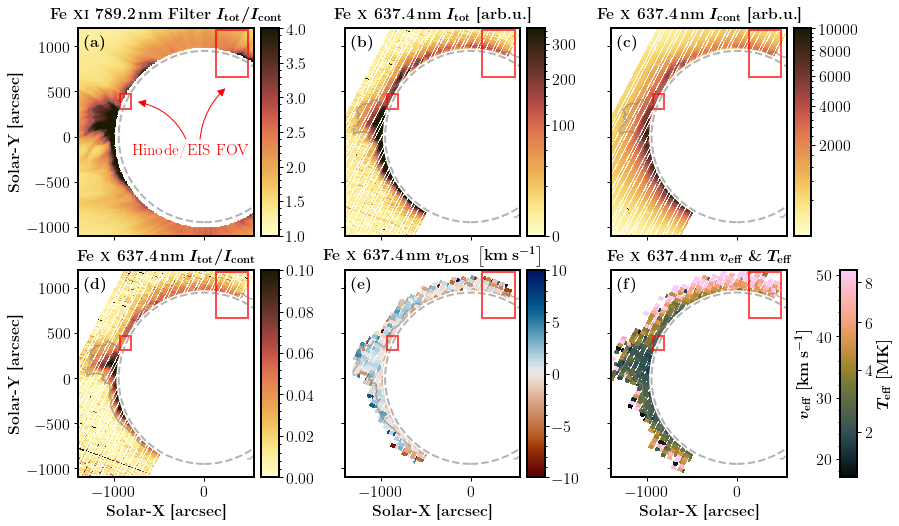

In [93]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11.5,7.2),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

# for ax_ in (ax2,ax3,ax4,ax5,ax6):
#     ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
#                         cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

ax1.annotate(r"Hinode/EIS FOV",(-760,390),(-800,-200),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.3","color":"red"},fontsize=16,color="red")

ax1.annotate(r"",(250,550),(-50,-50),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=-0.2","color":"red"},fontsize=16,color="red")

norm_red_line_int = ImageNormalize(red_line_int_masked,interval=ManualInterval(0,350),
                        stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.lajolla,rasterized=True,norm=norm_red_line_int)


plot_colorbar(im2, ax2,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

norm_red_cont_int = ImageNormalize(data=red_cont_masked,interval=ManualInterval(1e2,1e4),stretch=SqrtStretch())

im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,norm=norm_red_cont_int)

im3_clb, im3_clbax = plot_colorbar(im3, ax3,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
# im3_clbax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# im3_clbax.yaxis.get_offset_text().set_fontsize(16)
# im3_clbax.yaxis.get_offset_text().set(va="bottom",ha="left")
# im3_clbax.yaxis.get_offset_text().set_position((0.4,1.3))

im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_veff_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.18/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

clb, clb_ax6 = plot_colorbar(im6, ax6,width=colorbar_width,bbox_to_anchor=(1.3, 0., 1, 1),fontsize=16)
clb_ax6.yaxis.set_ticks_position("left")
clb_ax6.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=16)
clb_ax6.yaxis.set_label_position("left")
clb_ax6_teff = clb_ax6.secondary_yaxis("right",functions=(veff2teff, teff2veff))
clb_ax6_teff.tick_params(labelsize=16)
clb_ax6_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=16)

ax1.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax4.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax4.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax5.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax6.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)

ax1.set_title(r"\textbf{Fe \textsc{xi} 789.2\,nm Filter} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax2.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm tot}}$ \textbf{[arb.u.]}",fontsize=16,pad=10)
ax3.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm cont}}$ \textbf{[arb.u.]}",fontsize=16,pad=10)
ax4.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax5.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)
ax6.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{v_{\rm eff}\ \&\ T_{\rm eff}}$",fontsize=16,pad=10)

for ax_, text_ in zip((ax1,ax2,ax3,ax4,ax5,ax6),
                      ("a","b","c","d","e","f")):
    ax_.text(0.035,0.97,r"\textbf{("+text_+r")}",fontsize=16,
             va="top",ha="left",transform=ax_.transAxes)
    
xlim_zoomin = [-1400,550]
ylim_zoomin = [-1100,1200]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['grey'])
    plot_eis_fov(ax_,eis_atlas_30_fex_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}")
    plot_eis_fov(ax_,eis_ch_fex_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}")
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/ms/FeX_fit.pdf",dpi=300,format="pdf",bbox_inches="tight")

In [70]:
FeX_in_atlas30_FOV = np.where( \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) > eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) < eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Tx.value + 32) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) > eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) < eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Ty.value + 160))

In [71]:
red_veff_in_atlas30_FOV = red_veff_masked[FeX_in_atlas30_FOV]
red_veff_err_in_atlas30_FOV = red_veff_masked_err[FeX_in_atlas30_FOV]
red_veff_in_atlas30_FOV,red_veff_err_in_atlas30_FOV = np.unique([red_veff_in_atlas30_FOV,red_veff_err_in_atlas30_FOV],axis=1)
red_veff_in_atlas30_FOV = red_veff_in_atlas30_FOV[~np.isnan(red_veff_in_atlas30_FOV)]
red_veff_err_in_atlas30_FOV = red_veff_err_in_atlas30_FOV[~np.isnan(red_veff_err_in_atlas30_FOV)]

In [72]:
red_veff_in_atlas30_aver = np.nansum(red_veff_in_atlas30_FOV/red_veff_err_in_atlas30_FOV**2)/np.nansum(1./red_veff_err_in_atlas30_FOV**2)
red_veff_in_atlas30_aver_err = np.sqrt(1./(red_veff_in_atlas30_FOV.shape[0]-1)* \
(np.nansum(red_veff_in_atlas30_FOV**2/red_veff_err_in_atlas30_FOV**2)/np.nansum(1./red_veff_err_in_atlas30_FOV**2) - red_veff_in_atlas30_aver**2))

In [73]:
print("Average Fe X veff in Atlas 30 FOV: {:.2f} +/- {:.2f}".format(red_veff_in_atlas30_aver,red_veff_in_atlas30_aver_err))

Average Fe X veff in Atlas 30 FOV: 28.68 +/- 0.75
